# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os, sys
import math
import seaborn as sns
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as Func
from torchvision import transforms as T
from PIL import Image
from torchvision import transforms, utils
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.path.realpath('.')))
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from helpers.supernet import SuperNet 
from helpers.gradcam import NetworkGradCAM
from helpers.xrai import XRai
#from helpers.classynet import ClassyNet

# Data Read-Ins

In [3]:
TEST_PATH = '/home/jmryan/private/DSC180/A/test/testdata.csv'
TRAIN_PATH = '/home/jmryan/private/DSC180/A/train/traindata.csv'
VAL_PATH = '/home/jmryan/private/DSC180/A/val/valdata.csv'

FULL_HSIAO_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/segmented_datapaths_meta.csv'
HSIAO_DIR_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp_224_pandas/'
HSIAO_LUNG_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/seg_lung_224_pandas/'
HSIAO_HEART_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/seg_heart_224_pandas/'

FULL_MIMIC_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/final_mimic_paths.csv'
MIMIC_DIR_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/mimic_224_pandas/'
MIMIC_LUNG_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/mimic_seg_lung_224_pandas/'
MIMIC_HEART_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/mimic_seg_heart_224_pandas/'

In [58]:
mim.Edema.mean()

0.4871397582894329

In [26]:
test = pd.read_csv(TEST_PATH, header=0, index_col=0)
train = pd.read_csv(TRAIN_PATH, index_col = 0)
val = pd.read_csv(VAL_PATH, index_col = 0)
seg = pd.read_csv(FULL_HSIAO_PATH, index_col = 0)
mim = pd.read_csv(FULL_MIMIC_PATH, index_col=0)
seg['key'] = seg.filepaths.apply(lambda x: x.split('/')[0])

In [36]:
class ImageDataset(Dataset):
    def __init__(self, df, mimic, transform=None, target_transform=None, seg = False):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
        self.seg = seg
        if mimic:
            self.path = MIMIC_DIR_PATH
            if self.seg:
                self.heart = MIMIC_HEART_PATH
                self.lung = MIMIC_LUNG_PATH
        else:
            self.path = HSIAO_DIR_PATH
            if self.seg:
                self.heart = HSIAO_HEART_PATH
                self.lung = HSIAO_LUNG_PATH
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df[idx]
        filepath = row[1]
        
        val = row[0]
        if self.seg:
            full = torch.load(self.path + filepath + '/' + filepath + '_224.pandas')
            lung = torch.load(self.lung + filepath + '/' + filepath + '_224.pandas')
            heart = torch.load(self.heart + filepath + '/' + filepath + '_224.pandas')
            im = torch.stack([full, lung, heart])
#             print(self.path + filepath + '/' + filepath + '_224.pandas', 
#                   self.lung + filepath + '/' + filepath + '_224.pandas',
#                  self.heart + filepath + '/' + filepath + '_224.pandas')
        else:
            im = torch.load(self.path + filepath + '/' + filepath + '_224.pandas').view(1, 224, 224).expand(3, -1, -1)
        return im, int(val)

In [28]:
hsiao_train, hsiao_val = train_test_split(seg[['heart', 'id']].to_numpy(), test_size=0.2, random_state=42)
mim_train, temp = train_test_split(mim.to_numpy(), test_size=0.2, random_state=42)
mim_val, mim_test = train_test_split(temp, test_size=0.5, random_state=42)

In [29]:
hsiao_full_train_dataset = ImageDataset(hsiao_train, mimic=False, seg=False)
hsiao_full_val_dataset = ImageDataset(hsiao_val, mimic=False, seg=False)

mim_full_train_dataset = ImageDataset(mim_train, mimic=True, seg=False)
mim_full_val_dataset = ImageDataset(mim_val, mimic=True, seg=False)
mim_full_test_dataset = ImageDataset(mim_test, mimic=True, seg=False)


hsiao_seg_train_dataset = ImageDataset(hsiao_train, mimic=False, seg=True)
hsiao_seg_val_dataset = ImageDataset(hsiao_val, mimic=False, seg=True)

mim_seg_train_dataset = ImageDataset(mim_train, mimic=True, seg=True)
mim_seg_val_dataset = ImageDataset(mim_val, mimic=True, seg=True)
mim_seg_test_dataset = ImageDataset(mim_test, mimic=True, seg=True)

In [8]:
hsiao_full_train_dataset[0][1]

1

In [9]:
mim_full_train_dataset[0][1]

1

In [40]:
BATCH_SIZE = 32
hsiao_full_train_dl = DataLoader(hsiao_full_train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
hsiao_full_val_dl = DataLoader(hsiao_full_val_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

hsiao_seg_train_dl = DataLoader(hsiao_seg_train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
hsiao_seg_val_dl = DataLoader(hsiao_seg_val_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

mim_full_train_dl = DataLoader(mim_full_train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
mim_full_val_dl = DataLoader(mim_full_val_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

mim_seg_train_dl = DataLoader(mim_seg_train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
mim_seg_val_dl = DataLoader(mim_seg_val_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

# Model

In [4]:
import torch
import numpy as np
import pandas as pd
import math
import torch.nn as nn
import pytorch_lightning as pl
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as Func
from torchvision import transforms as T
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve
from helpers.lightning_interface import *
import matplotlib as mpl
from skimage.transform import resize
import os

In [9]:
class ClassyNet(SuperFace):
    def __init__(self, title, layer_defs, linear_layers, type_model = 'classifier', lr = 1e-3, is_transfer=False, model=None, lr_scheduler = [], batch_size =32, print_on = True):
        super().__init__(layer_defs = layer_defs, model = model, lr_scheduler = lr_scheduler, lr=lr)
        
        self.title = title
        self.model = model
        self.print = print_on
        self.linear_layers = linear_layers
        self.grad = False
        self.val_heart_true_epoch = np.array([])
        self.val_heart_hat_epoch = np.array([])
        self.train_heart_true_epoch = np.array([])
        self.train_heart_hat_epoch = np.array([])
        self.val_mae_epoch = np.array([])
        self.train_mae_epoch = np.array([])
        self.train_loss_epoch = np.array([])
        self.val_loss_epoch = np.array([])
        self.val_auc = np.array([])
        self.init_model()
        
#         self.l1_loss = nn.L1Loss()
#         self.l2_loss = nn.MSELoss()
#         self.l1_str = l1
#         self.l2_str = l2
    
        
        self.tr_fpath = self.get_savefname(dset='train')
        self.val_fpath = self.get_savefname(dset='valid')
        
        if os.path.isfile(self.tr_fpath):
            os.remove(self.tr_fpath)
            os.remove(self.val_fpath)
#             print('Experiment Title Already Exists: Choose New Title')
#             assert False
        
        self.BATCH_SIZE = batch_size
        if type_model == 'regressor':
            self.loss_func = self.mae
            
        elif type_model == 'classifier':
            self.loss_func = self.cbe
            
        else:
            print('Invalid Loss Func: Not Implemented')
            assert False
            
    def get_savefname(self, dset='train'):
        return f"epoch_logs/{self.title}_logs_{dset}.csv"
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=0.9) 
        lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience = 3, verbose=True)
        return {"optimizer": optim}# "lr_scheduler": {'scheduler': lr_sched, 'monitor': 'val_auc', 
                                    #                'interval': 'epoch'}}
    
    def init_model(self):
        layers = list(self.model.children())
        lin = layers[-1]
        layers = layers[:-1]
        temp_lin = [nn.Linear(num_in,num_out) for num_in, num_out in self.linear_layers]
        total_lin = []
        for lin in temp_lin[:-1]:
            #total_lin.append(nn.Dropout(0.75))
            total_lin.append(lin)
            total_lin.append(nn.ReLU())
            total_lin.append(nn.Dropout(0.75))
        total_lin.append(temp_lin[-1])
#         total_lin.append(nn.LogSoftmax())
        self.regresser = nn.Sequential(*total_lin)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.grad:
            represents = self.layers(x).flatten(1)
            y_hat = self.regresser(represents)
        else:
            represents = x
            for i in range(len(self.layers)):
                if True:#self.current_epoch >= 5 and (i == 8 or i==7 or i ==6 or i==5 or i==4):
                    represents = self.layers[i](represents)
                    
#                 elif self.current_epoch >= 10 and i == 7:
#                     represents = self.layers[i](represents)
                    
#                 elif self.current_epoch >= 15 and i == 6:
#                     represents = self.layers[i](represents)
                    
#                 elif self.current_epoch >= 20 and i == 5:
#                     represents = self.layers[i](represents)

                else:
                    with torch.no_grad():
                        represents = self.layers[i](represents)
            y_hat = self.regresser(represents.flatten(1))
        del x
        return y_hat
    
    
    def turn_grad(self, boo):
        self.grad = boo
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        y_hat = self(x)
        #print(y_hat.detach().mean().item(), y.mean().item(), y_hat.detach().median().item(), y.median().item())
        del x
        
#         loss = self.loss_func(y_hat, y)
        
        loss = self.loss_func(y_hat, y)
        
        arged = F.softmax(y_hat.detach())[:,1]
        

        
        loss_dic = {'loss': loss,
                    'y_hat': arged,
                    'y_true': y
                   }
        
        return loss_dic
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        y_hat = self(x)
        #print(y_hat.detach().mean().item(), y.mean().item(), y_hat.detach().median().item(), y.median().item())
        del x
        
#         loss = self.loss_func(y_hat, y)
        
        loss = self.loss_func(y_hat, y).detach()
        
        arged = F.softmax(y_hat.detach())[:,1]

#         arged = self.softmax_np(y_hat.cpu().detach().numpy())[:,1]
    
#         print(f"Arged: {arged}")

        
        loss_dic = {'loss': loss,
                    'y_hat': arged,
                    'y_true': y
                   }
        
        return loss_dic
    
        
    def training_step_end(self, batch_loss):
        total_loss = batch_loss['loss'].mean()
        heart_true = batch_loss['y_true'].to('cpu').numpy()
        heart_hat = batch_loss['y_hat'].to('cpu').numpy()
        
        self.train_heart_true_epoch = np.append(self.train_heart_true_epoch, heart_true)
        self.train_heart_hat_epoch = np.append(self.train_heart_hat_epoch, heart_hat)
        
        torch.cuda.empty_cache()
        out = 'training_step (pre del) mem %:', torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()
        #print(out)        
        return total_loss
    
    def validation_step_end(self, batch_loss):
        total_loss = batch_loss['loss'].mean()
        heart_true = batch_loss['y_true'].to('cpu').numpy()
        heart_hat = batch_loss['y_hat'].to('cpu').numpy()
        
        
        self.val_heart_true_epoch = np.append(self.val_heart_true_epoch, heart_true)
        self.val_heart_hat_epoch = np.append(self.val_heart_hat_epoch, heart_hat)
        
        return total_loss
        
    def training_epoch_end(self, step_outputs):
        
        losses = [loss['loss'] for loss in step_outputs]
        
        heart_true = self.train_heart_true_epoch
        heart_hat = self.train_heart_hat_epoch
        total_loss = sum(losses)/len(losses)
        #print(heart_hat)
        auc = roc_auc_score(heart_true, heart_hat)
        prc = precision_score(heart_true, (heart_hat > 0.5).astype(int), zero_division=0)
        acc = accuracy_score(heart_true, (heart_hat > 0.5).astype(int))
        
# #         self.log('train_AUC', auc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=self.BATCH_SIZE)
        
#         self.log('train_PRC', prc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=self.BATCH_SIZE)
        
        self.log('loss', total_loss,
                on_step=False, on_epoch=True, prog_bar=False, batch_size=self.BATCH_SIZE)
        
        
        info_dic = {'Epoch': [self.current_epoch], 'AUC': [auc], 'PRC': [prc], 'Accuracy': [acc], 'loss':[total_loss.item()]}
        print(f"Epoch {self.current_epoch}")
        if self.print:
            print(f"\tTrain {info_dic};")
#        print(f"\tTrain loss: {total_loss.item()}; mean_mae: {epoch_mae.mean()};" + 
 #            f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
    
        if not os.path.isfile(self.tr_fpath):
            pd.DataFrame.from_dict(info_dic).to_csv(self.tr_fpath)
            
        else:
            pd.concat([pd.read_csv(self.tr_fpath, index_col=0), pd.DataFrame.from_dict(info_dic)]).to_csv(self.tr_fpath)
            
        
        self.train_loss_epoch = np.append(self.train_loss_epoch, total_loss.item())
        
        self.train_heart_true_epoch = np.array([])
        self.train_heart_hat_epoch = np.array([])
        #sch = self.lr_schedulers()
        #print(self.lr_schedulers())

        # If the selected scheduler is a ReduceLROnPlateau scheduler.

        return None
        
    def validation_epoch_end(self, step_outputs):
        losses = step_outputs

        heart_true = self.val_heart_true_epoch
        heart_hat = self.val_heart_hat_epoch
        total_loss = sum(losses)/len(losses)
        
#         print(f'HAT: {heart_hat}')

        auc = roc_auc_score(heart_true, heart_hat)
        prc = precision_score(heart_true, (heart_hat > 0.5).astype(int), zero_division=0)
        acc = accuracy_score(heart_true, (heart_hat > 0.5).astype(int))
        self.log('val_auc', auc)

#         self.log('val_AUC', auc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=self.BATCH_SIZE)
        
#         self.log('val_PRC', prc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=self.BATCH_SIZE)
        
# #         self.log('val_loss', total_loss,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=self.BATCH_SIZE)
        
        
        info_dic = {'Epoch': [self.current_epoch], 'AUC': [auc], 'PRC': [prc], 'Accuracy': [acc], 'loss':[total_loss.item()]}  
        
        if self.print:
            print(f"\tVal {info_dic}")
#         print(f"\tVal loss: {total_loss.item()}; mean_mae: {epoch_mae.mean()};" + 
#              f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")

        if not os.path.isfile(self.val_fpath):
            pd.DataFrame.from_dict(info_dic).to_csv(self.val_fpath)
            
        else:
            pd.concat([pd.read_csv(self.val_fpath, index_col=0), pd.DataFrame.from_dict(info_dic)]).to_csv(self.val_fpath)
        
        self.val_auc = np.append(self.val_auc, auc)
        self.val_heart_true_epoch = np.array([])
        self.val_heart_hat_epoch = np.array([])
        self.val_loss_epoch = np.append(self.val_loss_epoch, total_loss.item())

        
        return None
        
    def get_classbalance_weights(self, y_hat, y_true, beta=0.999):
        # Get class counts
        classes, counts = torch.unique(y_true, return_counts=True)
#         print(classes,counts)
        if 1 not in classes: # Case where there are no sick samples
            counts = torch.tensor([counts[0], 0]).type_as(y_hat)#.device)
        if 0 not in classes: # Case where there are no healthy samples
            counts = torch.tensor([0, counts[0]]).type_as(y_hat)#.device)
        # Calculate weight for each class
        beta = torch.tensor(beta).type_as(y_hat)#.device)        
        one = torch.tensor(1.).type_as(y_hat)#.device)
        weights = (one - torch.pow(beta, counts)) / (one - beta)
        return weights        
    
    def cbe(self, y_hat, y_true, beta=0.9):
        weights = self.get_classbalance_weights(y_hat, y_true, beta=beta)
#         print(weights)
#         print(torch.unique(y_hat))
        cb_ce_loss = F.cross_entropy(y_hat, y_true, weight=weights)
        return cb_ce_loss 
    
    def mae(self, y_hat, y_true):
        y_true = y_true.view(-1,1)
        return torch.abs(y_true - y_hat)
    
    def softmax_np(x, axis=1):
        return np.exp(x)/np.sum(np.exp(x), axis=axis).reshape(-1,1)

In [10]:
torch.cuda.is_available()

True

In [11]:
model = resnet152(weights=ResNet152_Weights.DEFAULT)

In [13]:
early_stop_callback = EarlyStopping(monitor="val_auc", min_delta=0.01, patience=8, verbose=False, mode="max",stopping_threshold = 0.9)

#### Train Loop

In [85]:
final_lin = [[2048, 4096], [4096, 2]]
titles = ['hsiao_base_full_9_reg', 'mim_base_full_5_reg', 'hsiao_base_seg_5_reg', 'mim_base_seg_5_reg']
train_vals = [[hsiao_full_train_dl, hsiao_full_val_dl], [mim_full_train_dl, mim_full_val_dl],
              [hsiao_seg_train_dl, hsiao_seg_val_dl], [mim_seg_train_dl, mim_seg_val_dl]]

for i in range(4):
    print(titles[i])
    net = ClassyNet(title= titles[i], layer_defs=None, linear_layers = final_lin, is_transfer=True, 
       model = model, lr_scheduler=True, lr = 1e-5, print_on = True)
    #net.load_state_dict(torch.load(f'models/{titles[i]}'))
    trainer = pl.Trainer(
        accelerator='gpu',
        max_epochs=35, 
        enable_progress_bar=False,
        check_val_every_n_epoch = 1,
        #callbacks=[early_stop_callback],
        logger=False,
        enable_checkpointing=False)
    net.train()
    trainer.fit(net, train_vals[i][0], train_vals[i][1])
    torch.save(net.state_dict(), f'models/{titles[i]}')

hsiao_base_full_9_reg


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 8.4 M 
2 | layers    | Sequential | 58.1 M
-----------------------------------------
68.6 M    Trainable params
0         Non-trainable params
68.6 M    Total params
274.375   Total estimated model params size (MB)


	Val {'Epoch': [0], 'AUC': [0.4488636363636364], 'PRC': [0.6857142857142857], 'Accuracy': [0.515625], 'loss': [18.104846954345703]}


/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [0], 'AUC': [0.7662450289233449], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [0.5454248189926147]}
Epoch 0
	Train {'Epoch': [0], 'AUC': [0.6889417191153401], 'PRC': [0.6471780480199564], 'Accuracy': [0.6368559608875517], 'loss': [0.5899604558944702]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [1], 'AUC': [0.7510732871969042], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [0.6612076163291931]}
Epoch 1
	Train {'Epoch': [1], 'AUC': [0.7645459033545051], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.5361729264259338]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [2], 'AUC': [0.7795791878116536], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [439.4237976074219]}
Epoch 2
	Train {'Epoch': [2], 'AUC': [0.785164334386717], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.5154274702072144]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [3], 'AUC': [0.7805233177214052], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [2.860776901245117]}
Epoch 3
	Train {'Epoch': [3], 'AUC': [0.8035335599659119], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.49804753065109253]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [4], 'AUC': [0.7696955989506512], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [2.8487069606781006]}
Epoch 4
	Train {'Epoch': [4], 'AUC': [0.8171345497639773], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.48427751660346985]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [5], 'AUC': [0.802330983393725], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [0.5273207426071167]}
Epoch 5
	Train {'Epoch': [5], 'AUC': [0.8247985499201662], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.47478893399238586]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [6], 'AUC': [0.8004356248530959], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [0.7111476063728333]}
Epoch 6
	Train {'Epoch': [6], 'AUC': [0.8323050479661689], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.4700988829135895]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [7], 'AUC': [0.7888493288553549], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [66.5290298461914]}
Epoch 7
	Train {'Epoch': [7], 'AUC': [0.8422498927439618], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.45783692598342896]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [8], 'AUC': [0.8075919244948472], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [0.5111986398696899]}
Epoch 8
	Train {'Epoch': [8], 'AUC': [0.8414290086925704], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.45871108770370483]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [9], 'AUC': [0.8185791673042369], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [0.5143934488296509]}
Epoch 9
	Train {'Epoch': [9], 'AUC': [0.8524212164881246], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.44556352496147156]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [10], 'AUC': [0.810524287879959], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [0.4958389401435852]}
Epoch 10
	Train {'Epoch': [10], 'AUC': [0.8608588649283508], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.4374590218067169]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [11], 'AUC': [0.8065156794974737], 'PRC': [0.6432009626955475], 'Accuracy': [0.6432009626955475], 'loss': [1.0841505527496338]}
Epoch 11
	Train {'Epoch': [11], 'AUC': [0.8630497720542843], 'PRC': [0.6471605866867244], 'Accuracy': [0.6471605866867244], 'loss': [0.43302881717681885]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [12], 'AUC': [0.743470162497614], 'PRC': [0.6782905982905983], 'Accuracy': [0.6705776173285198], 'loss': [0.9319125413894653]}
Epoch 12
	Train {'Epoch': [12], 'AUC': [0.8666768794037782], 'PRC': [0.68797489263297], 'Accuracy': [0.6952237683339602], 'loss': [0.4309599697589874]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [13], 'AUC': [0.8098335428770643], 'PRC': [0.7104233368907862], 'Accuracy': [0.7126955475330926], 'loss': [17.89777374267578]}
Epoch 13
	Train {'Epoch': [13], 'AUC': [0.8675224157439276], 'PRC': [0.7222569413445228], 'Accuracy': [0.7273411056788266], 'loss': [0.4283147156238556]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [14], 'AUC': [0.8004233992778234], 'PRC': [0.7402234636871509], 'Accuracy': [0.7190132370637786], 'loss': [3.318085193634033]}
Epoch 14
	Train {'Epoch': [14], 'AUC': [0.8761506300926798], 'PRC': [0.7717735550277118], 'Accuracy': [0.765927040240692], 'loss': [0.4156605303287506]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [15], 'AUC': [0.8193470123060274], 'PRC': [0.7580385852090032], 'Accuracy': [0.7430806257521059], 'loss': [0.5011957883834839]}
Epoch 15
	Train {'Epoch': [15], 'AUC': [0.8748092978225414], 'PRC': [0.7978267683627626], 'Accuracy': [0.7816472358029334], 'loss': [0.415927916765213]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [16], 'AUC': [0.8153244036679881], 'PRC': [0.7714646464646465], 'Accuracy': [0.7448856799037304], 'loss': [0.4802647829055786]}
Epoch 16
	Train {'Epoch': [16], 'AUC': [0.8773398119052667], 'PRC': [0.8265654231319467], 'Accuracy': [0.7992478375329071], 'loss': [0.41312071681022644]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [17], 'AUC': [0.8036359649607125], 'PRC': [0.7734668335419274], 'Accuracy': [0.7512033694344163], 'loss': [1.7559062242507935]}
Epoch 17
	Train {'Epoch': [17], 'AUC': [0.8824155075631239], 'PRC': [0.8460842009959257], 'Accuracy': [0.8128619781872884], 'loss': [0.40437260270118713]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [18], 'AUC': [0.8053061362922906], 'PRC': [0.8507867607162235], 'Accuracy': [0.7457882069795427], 'loss': [0.4980427622795105]}
Epoch 18
	Train {'Epoch': [18], 'AUC': [0.8854565098444146], 'PRC': [0.8592558354518142], 'Accuracy': [0.8205340353516359], 'loss': [0.3979830741882324]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [19], 'AUC': [0.8140413098244723], 'PRC': [0.8328402366863905], 'Accuracy': [0.762936221419976], 'loss': [0.47821876406669617]}
Epoch 19
	Train {'Epoch': [19], 'AUC': [0.8922917842915318], 'PRC': [0.8721215663354763], 'Accuracy': [0.83174125611132], 'loss': [0.39069482684135437]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [20], 'AUC': [0.8288543689473542], 'PRC': [0.8084532374100719], 'Accuracy': [0.7695547533092659], 'loss': [0.4730660319328308]}
Epoch 20
	Train {'Epoch': [20], 'AUC': [0.8915762609013906], 'PRC': [0.8776620918125887], 'Accuracy': [0.833019932305378], 'loss': [0.39527571201324463]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [21], 'AUC': [0.8174887248646115], 'PRC': [0.7917967008470798], 'Accuracy': [0.7506016847172082], 'loss': [0.4937630593776703]}
Epoch 21
	Train {'Epoch': [21], 'AUC': [0.9000625697387235], 'PRC': [0.8783799602013345], 'Accuracy': [0.8391124482888304], 'loss': [0.3829014003276825]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [22], 'AUC': [0.8223487854088153], 'PRC': [0.7861715749039693], 'Accuracy': [0.7602286401925391], 'loss': [0.47554272413253784]}
Epoch 22
	Train {'Epoch': [22], 'AUC': [0.903810039720164], 'PRC': [0.8856270549553781], 'Accuracy': [0.8468597216998872], 'loss': [0.3787153959274292]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [23], 'AUC': [0.8241954388350525], 'PRC': [0.8095238095238095], 'Accuracy': [0.7674488567990373], 'loss': [0.4773856997489929]}
Epoch 23
	Train {'Epoch': [23], 'AUC': [0.9089395616064908], 'PRC': [0.8944319659534223], 'Accuracy': [0.8547574276043626], 'loss': [0.3704429268836975]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [24], 'AUC': [0.8284272625596094], 'PRC': [0.8161290322580645], 'Accuracy': [0.7695547533092659], 'loss': [0.4730386435985565]}
Epoch 24
	Train {'Epoch': [24], 'AUC': [0.9122112300268148], 'PRC': [0.8932955618508026], 'Accuracy': [0.854080481383979], 'loss': [0.3666791319847107]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [25], 'AUC': [0.8309494776129999], 'PRC': [0.8202451202905129], 'Accuracy': [0.7812876052948255], 'loss': [0.47781962156295776]}
Epoch 25
	Train {'Epoch': [25], 'AUC': [0.9118722796385177], 'PRC': [0.9017409968995945], 'Accuracy': [0.8596464836404664], 'loss': [0.3599432110786438]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [26], 'AUC': [0.8220612872032143], 'PRC': [0.8257940327237728], 'Accuracy': [0.7641395908543923], 'loss': [0.4792832136154175]}
Epoch 26
	Train {'Epoch': [26], 'AUC': [0.916339571675526], 'PRC': [0.903958856596101], 'Accuracy': [0.8609251598345242], 'loss': [0.35934311151504517]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [27], 'AUC': [0.8253079661848477], 'PRC': [0.8017857142857143], 'Accuracy': [0.7635379061371841], 'loss': [0.47455689311027527]}
Epoch 27
	Train {'Epoch': [27], 'AUC': [0.9121426000370058], 'PRC': [0.899200763449839], 'Accuracy': [0.8562617525385483], 'loss': [0.36705103516578674]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [28], 'AUC': [0.817099478322872], 'PRC': [0.840080971659919], 'Accuracy': [0.7611311672683514], 'loss': [0.48743078112602234]}
Epoch 28
	Train {'Epoch': [28], 'AUC': [0.92333296763707], 'PRC': [0.9071555292726198], 'Accuracy': [0.8707032719067318], 'loss': [0.35170575976371765]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [29], 'AUC': [0.7684986756941367], 'PRC': [0.7427066450567261], 'Accuracy': [0.717208182912154], 'loss': [0.5557730793952942]}
Epoch 29
	Train {'Epoch': [29], 'AUC': [0.9260374847589392], 'PRC': [0.9116361488481984], 'Accuracy': [0.8770214366303122], 'loss': [0.3433271050453186]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [30], 'AUC': [0.8124427172642477], 'PRC': [0.8193963384463137], 'Accuracy': [0.7451865222623345], 'loss': [0.4888979196548462]}
Epoch 30
	Train {'Epoch': [30], 'AUC': [0.9204344159429299], 'PRC': [0.9127565102604104], 'Accuracy': [0.8702519744264762], 'loss': [0.3474635183811188]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [31], 'AUC': [0.8091656715311311], 'PRC': [0.8489473684210527], 'Accuracy': [0.7557160048134778], 'loss': [0.4929320812225342]}
Epoch 31
	Train {'Epoch': [31], 'AUC': [0.9198951997757062], 'PRC': [0.9139655380166285], 'Accuracy': [0.8696502444528018], 'loss': [0.3493102788925171]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [32], 'AUC': [0.7986579867711389], 'PRC': [0.8269809428284854], 'Accuracy': [0.7490974729241877], 'loss': [0.5270308256149292]}
Epoch 32
	Train {'Epoch': [32], 'AUC': [0.9330619128729147], 'PRC': [0.9170818505338079], 'Accuracy': [0.8817600601729974], 'loss': [0.33809739351272583]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [33], 'AUC': [0.8124632246808337], 'PRC': [0.8023203926818384], 'Accuracy': [0.7644404332129964], 'loss': [0.5366880893707275]}
Epoch 33
	Train {'Epoch': [33], 'AUC': [0.9324357199622886], 'PRC': [0.9160549372484016], 'Accuracy': [0.8814591951861602], 'loss': [0.3356795310974121]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
`Trainer.fit` stopped: `max_epochs=35` reached.


	Val {'Epoch': [34], 'AUC': [0.7996092154020162], 'PRC': [0.833589349718382], 'Accuracy': [0.7487966305655837], 'loss': [0.5070982575416565]}
Epoch 34
	Train {'Epoch': [34], 'AUC': [0.9349196300699848], 'PRC': [0.9225393817363496], 'Accuracy': [0.8895073335840542], 'loss': [0.32863155007362366]};
mim_base_full_5_reg


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 8.4 M 
2 | layers    | Sequential | 58.1 M
-----------------------------------------
68.6 M    Trainable params
0         Non-trainable params
68.6 M    Total params
274.375   Total estimated model params size (MB)


	Val {'Epoch': [0], 'AUC': [0.707843137254902], 'PRC': [0.5], 'Accuracy': [0.53125], 'loss': [0.6884602308273315]}


/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [0], 'AUC': [0.8910800352464902], 'PRC': [0.7905629139072847], 'Accuracy': [0.8167330677290837], 'loss': [0.43230685591697693]}
Epoch 0
	Train {'Epoch': [0], 'AUC': [0.8549051197430388], 'PRC': [0.7671492204899777], 'Accuracy': [0.7783741906922694], 'loss': [0.4819127023220062]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [1], 'AUC': [0.8816632015980082], 'PRC': [0.8410732714138287], 'Accuracy': [0.7985834440017707], 'loss': [0.4633188247680664]}
Epoch 1
	Train {'Epoch': [1], 'AUC': [0.8977654727017328], 'PRC': [0.818108605614358], 'Accuracy': [0.8188810801837197], 'loss': [0.40892645716667175]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [2], 'AUC': [0.8907852692248595], 'PRC': [0.8370221327967807], 'Accuracy': [0.8025675077467906], 'loss': [0.4229121208190918]}
Epoch 2
	Train {'Epoch': [2], 'AUC': [0.9081919352443459], 'PRC': [0.827598033611524], 'Accuracy': [0.8300038736096508], 'loss': [0.38936445116996765]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [3], 'AUC': [0.8911231526166756], 'PRC': [0.8100358422939068], 'Accuracy': [0.8123063302346171], 'loss': [0.42150789499282837]}
Epoch 3
	Train {'Epoch': [3], 'AUC': [0.9184421486260104], 'PRC': [0.8409222569806512], 'Accuracy': [0.8385258148414587], 'loss': [0.36934345960617065]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [4], 'AUC': [0.889072333700223], 'PRC': [0.805277525022748], 'Accuracy': [0.8030101814962373], 'loss': [0.42625692486763]}
Epoch 4
	Train {'Epoch': [4], 'AUC': [0.929208497064038], 'PRC': [0.8596573574278339], 'Accuracy': [0.8520834486193348], 'loss': [0.3469720482826233]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [5], 'AUC': [0.8740596493538666], 'PRC': [0.7578125], 'Accuracy': [0.798140770252324], 'loss': [0.45784834027290344]}
Epoch 5
	Train {'Epoch': [5], 'AUC': [0.9414467794089305], 'PRC': [0.8788705659034286], 'Accuracy': [0.8663051297659233], 'loss': [0.3186739683151245]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [6], 'AUC': [0.8676963094666931], 'PRC': [0.8463385354141657], 'Accuracy': [0.7613988490482514], 'loss': [0.4895583689212799]}
Epoch 6
	Train {'Epoch': [6], 'AUC': [0.9503527642982385], 'PRC': [0.8928571428571429], 'Accuracy': [0.8780919705605666], 'loss': [0.2945311665534973]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [7], 'AUC': [0.8768536549418777], 'PRC': [0.8357221609702316], 'Accuracy': [0.7755644090305445], 'loss': [0.46270057559013367]}
Epoch 7
	Train {'Epoch': [7], 'AUC': [0.9626581964764533], 'PRC': [0.9089195239778485], 'Accuracy': [0.8969619832881413], 'loss': [0.25700339674949646]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/home/jmryan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


hsiao_base_seg_5_reg


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 8.4 M 
2 | layers    | Sequential | 58.1 M
-----------------------------------------
68.6 M    Trainable params
0         Non-trainable params
68.6 M    Total params
274.375   Total estimated model params size (MB)


	Val {'Epoch': [0], 'AUC': [0.49431818181818177], 'PRC': [0.6875], 'Accuracy': [0.6875], 'loss': [1.316581130027771]}


/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [0], 'AUC': [0.8244446828212526], 'PRC': [0.7496217851739788], 'Accuracy': [0.7539109506618532], 'loss': [0.4801582992076874]}
Epoch 0
	Train {'Epoch': [0], 'AUC': [0.7700722279851593], 'PRC': [0.7297979797979798], 'Accuracy': [0.7224520496427228], 'loss': [0.517494797706604]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [1], 'AUC': [0.8127128630404296], 'PRC': [0.7457434733257662], 'Accuracy': [0.7475932611311673], 'loss': [0.4997597336769104]}
Epoch 1
	Train {'Epoch': [1], 'AUC': [0.8172548628435848], 'PRC': [0.7607482127117814], 'Accuracy': [0.7533659270402407], 'loss': [0.4732549488544464]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [2], 'AUC': [0.8289716950326305], 'PRC': [0.7208480565371025], 'Accuracy': [0.7328519855595668], 'loss': [0.47231730818748474]}
Epoch 2
	Train {'Epoch': [2], 'AUC': [0.8304719335055178], 'PRC': [0.7725772577257726], 'Accuracy': [0.7628431741256111], 'loss': [0.46027493476867676]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [3], 'AUC': [0.8404877925659037], 'PRC': [0.7357531760435572], 'Accuracy': [0.7475932611311673], 'loss': [0.4614015519618988]}
Epoch 3
	Train {'Epoch': [3], 'AUC': [0.846275834483691], 'PRC': [0.7856998177030585], 'Accuracy': [0.7772094772470853], 'loss': [0.4409267008304596]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [4], 'AUC': [0.8397238912980722], 'PRC': [0.7663297045101088], 'Accuracy': [0.7689530685920578], 'loss': [0.450466126203537]}
Epoch 4
	Train {'Epoch': [4], 'AUC': [0.8540557127851279], 'PRC': [0.7883211678832117], 'Accuracy': [0.7806694245957126], 'loss': [0.4322340786457062]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [5], 'AUC': [0.8269544751126725], 'PRC': [0.6913702239789197], 'Accuracy': [0.7063778580024067], 'loss': [0.5177794694900513]}
Epoch 5
	Train {'Epoch': [5], 'AUC': [0.8700621465617465], 'PRC': [0.8013930144422821], 'Accuracy': [0.7954870251974426], 'loss': [0.4124353528022766]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [6], 'AUC': [0.8137114164788135], 'PRC': [0.7254545454545455], 'Accuracy': [0.7298435619735258], 'loss': [0.49052897095680237]}
Epoch 6
	Train {'Epoch': [6], 'AUC': [0.8873675081942227], 'PRC': [0.8152681257131003], 'Accuracy': [0.8100789770590447], 'loss': [0.3868379592895508]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [7], 'AUC': [0.8046794769662275], 'PRC': [0.7650753768844221], 'Accuracy': [0.7376654632972323], 'loss': [0.5214261412620544]}
Epoch 7
	Train {'Epoch': [7], 'AUC': [0.9088913224042676], 'PRC': [0.8386513507764305], 'Accuracy': [0.8318164723580294], 'loss': [0.35401931405067444]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [8], 'AUC': [0.8080229746165508], 'PRC': [0.7427689934438874], 'Accuracy': [0.7355595667870036], 'loss': [0.48790115118026733]}
Epoch 8
	Train {'Epoch': [8], 'AUC': [0.9272105620612823], 'PRC': [0.858109559613319], 'Accuracy': [0.8543813463708161], 'loss': [0.3221897780895233]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [9], 'AUC': [0.8089637523524373], 'PRC': [0.7498045347928068], 'Accuracy': [0.7412755716004813], 'loss': [0.5192162990570068]}
Epoch 9
	Train {'Epoch': [9], 'AUC': [0.9406220265499451], 'PRC': [0.8758403816959445], 'Accuracy': [0.8742384355020685], 'loss': [0.2925333082675934]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/home/jmryan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


mim_base_seg_5_reg


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 8.4 M 
2 | layers    | Sequential | 58.1 M
-----------------------------------------
68.6 M    Trainable params
0         Non-trainable params
68.6 M    Total params
274.375   Total estimated model params size (MB)


	Val {'Epoch': [0], 'AUC': [0.2392156862745098], 'PRC': [0.13333333333333333], 'Accuracy': [0.359375], 'loss': [0.7725465297698975]}


/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [0], 'AUC': [0.8897261498226701], 'PRC': [0.8334919124643198], 'Accuracy': [0.816290393979637], 'loss': [0.4338543117046356]}
Epoch 0
	Train {'Epoch': [0], 'AUC': [0.8730629874629294], 'PRC': [0.7735259243289857], 'Accuracy': [0.7937026174533783], 'loss': [0.45156756043434143]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [1], 'AUC': [0.8874009476414015], 'PRC': [0.7554388597149287], 'Accuracy': [0.8074369189907038], 'loss': [0.4385293424129486]}
Epoch 1
	Train {'Epoch': [1], 'AUC': [0.895407525027148], 'PRC': [0.8003506465044926], 'Accuracy': [0.8162248907088706], 'loss': [0.4126812815666199]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcafd7b19d0>
Traceback (most recent call last):
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcafd7b19d0>
Traceback (most recent call last):
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/

	Val {'Epoch': [2], 'AUC': [0.889780242523448], 'PRC': [0.7969283276450512], 'Accuracy': [0.8140770252324038], 'loss': [0.42965683341026306]}
Epoch 2
	Train {'Epoch': [2], 'AUC': [0.9033051899313761], 'PRC': [0.807092665788318], 'Accuracy': [0.8224226661501853], 'loss': [0.39860889315605164]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [3], 'AUC': [0.8880618193335152], 'PRC': [0.7629343629343629], 'Accuracy': [0.8074369189907038], 'loss': [0.44513699412345886]}
Epoch 3
	Train {'Epoch': [3], 'AUC': [0.912341815780521], 'PRC': [0.8183518538893167], 'Accuracy': [0.8331027613303083], 'loss': [0.3824298083782196]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [4], 'AUC': [0.8902553175476722], 'PRC': [0.8052721088435374], 'Accuracy': [0.8238158477202302], 'loss': [0.4402158558368683]}
Epoch 4
	Train {'Epoch': [4], 'AUC': [0.9191729829714836], 'PRC': [0.8252104563579974], 'Accuracy': [0.8378064301920204], 'loss': [0.3707605302333832]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/tmp/ipykernel_380/1966578332.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]


	Val {'Epoch': [5], 'AUC': [0.8764577590883578], 'PRC': [0.7782462057335582], 'Accuracy': [0.798140770252324], 'loss': [0.4402843713760376]}
Epoch 5
	Train {'Epoch': [5], 'AUC': [0.9316752498988677], 'PRC': [0.8476880222841225], 'Accuracy': [0.8582258867799236], 'loss': [0.3432949483394623]};


/tmp/ipykernel_380/1966578332.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  arged = F.softmax(y_hat.detach())[:,1]
/home/jmryan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Testing

In [9]:
final_model_paths = ['hsiao_base_full_9_reg', 'mim_base_seg_5_reg','hsiao_base_seg_5_reg', 'mim_base_full_5_reg']

In [10]:
final_lin = [[2048, 4096], [4096, 2]]

In [ ]:
#mim_full_test_dataset, mim_seg_test_dataset

In [94]:
best_model = ClassyNet(title= 'best_model', layer_defs=None, linear_layers = final_lin, is_transfer=True, 
       model = model, lr_scheduler=True, lr = 1e-5, print_on = True)
best_model.to('cuda')
best_model.load_state_dict(torch.load(f'models/mim_base_seg_5_reg'))

<All keys matched successfully>

#### Get Test Probs

In [33]:
all_probs = []
all_grounds = []
for each in final_model_paths:
    title = each + '_eval'
    print(title)
    net = ClassyNet(title= title, layer_defs=None, linear_layers = final_lin, is_transfer=True, 
       model = model, lr_scheduler=True, lr = 1e-5, print_on = True)
    net.to('cuda')
    net.load_state_dict(torch.load(f'models/{each}'))
    net.eval()
    if 'seg' in title:
        test = mim_seg_test_dataset
    else:
        test = mim_full_test_dataset
    probs = []
    grounds = []
    for i in range(len(test)):
        grounds.append(test[i][1])
        probs.append(F.softmax(net(test[i][0].view((1,3,224,224)).to('cuda')).detach())[:,1].item())
        if i % 100 == 0:
            print(i)
    np.array(probs).tofile(f'{title}.csv', sep = ',')
    np.array(grounds).tofile(f'{each}_grounds.csv', sep = ',')
#     for i in grounds:
#         print(i)

hsiao_base_full_9_reg_eval


/tmp/ipykernel_174846/1525397281.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs.append(F.softmax(net(test[i][0].view((1,3,224,224)).to('cuda')).detach())[:,1].item())


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
mim_base_seg_5_reg_eval
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
hsiao_base_seg_5_reg_eval
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
mim_base_full_5_reg_eval
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


#### Analyze Results

In [10]:
hsiao_full = np.loadtxt('models/' + final_model_paths[0] + '_eval.csv',
                 delimiter=",", dtype=float)
mim_seg = np.loadtxt('models/' + final_model_paths[1] + '_eval.csv',
                 delimiter=",", dtype=float)
hsiao_seg = np.loadtxt('models/' + final_model_paths[2] + '_eval.csv',
                 delimiter=",", dtype=float)
mim_full = np.loadtxt('models/' + final_model_paths[3] + '_eval.csv',
                 delimiter=",", dtype=float)
full_ground = np.loadtxt('models/' + final_model_paths[3] + '_grounds.csv',
                 delimiter=",", dtype=float)

seg_ground = np.loadtxt('models/' + final_model_paths[2] + '_grounds.csv',
                 delimiter=",", dtype=float)

In [12]:
hsiao_full_auc = roc_auc_score(full_ground, hsiao_full)
hsiao_full_prc = precision_score(full_ground, (hsiao_full > 0.5).astype(int), zero_division=0)
hsiao_full_acc = accuracy_score(full_ground, (hsiao_full > 0.5).astype(int))

mim_seg_auc = roc_auc_score(seg_ground, mim_seg)
mim_seg_prc = precision_score(seg_ground, (mim_seg > 0.5).astype(int), zero_division=0)
mim_seg_acc = accuracy_score(seg_ground, (mim_seg > 0.5).astype(int))

hsiao_seg_auc = roc_auc_score(seg_ground, hsiao_seg)
hsiao_seg_prc = precision_score(seg_ground, (hsiao_seg > 0.5).astype(int), zero_division=0)
hsiao_seg_acc = accuracy_score(seg_ground, (hsiao_seg > 0.5).astype(int))

mim_full_auc = roc_auc_score(full_ground, mim_full)
mim_full_prc = precision_score(full_ground, (mim_full > 0.5).astype(int), zero_division=0)
mim_full_acc = accuracy_score(full_ground, (mim_full > 0.5).astype(int))

#### Get XRAI Examples

In [5]:
import PIL.Image
from matplotlib import pylab as P
import torch
from torchvision import models, transforms

In [6]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [98]:
j = 2
print(mim_seg[j], seg_ground[j])

0.9282153844833374 1.0


In [102]:
xr = XRai(best_model)
xr.eval();

In [104]:
x_out = xr(mim_seg_test_dataset[2][0])

tensor([[[0.5490, 0.5529, 0.5490,  ..., 0.9333, 0.9333, 0.9373],
         [0.5373, 0.5373, 0.5333,  ..., 0.9216, 0.9216, 0.9255],
         [0.5216, 0.5216, 0.5176,  ..., 0.9098, 0.9098, 0.9098],
         ...,
         [0.0118, 0.0157, 0.0157,  ..., 0.1804, 0.0824, 0.0627],
         [0.0118, 0.0157, 0.0157,  ..., 0.1804, 0.0863, 0.0627],
         [0.0118, 0.0157, 0.0157,  ..., 0.1765, 0.0941, 0.0706]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

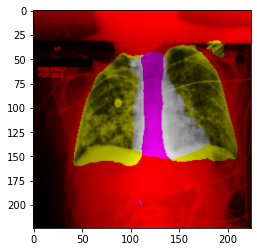

In [99]:
plt.imshow(torch.moveaxis(mim_seg_test_dataset[2][0],0,2))

In [152]:
j = 23
print(mim_seg[j], seg_ground[j])

0.7701541185379028 0.0


In [153]:
x_out = xr(mim_seg_test_dataset[j][0])

tensor([[[0.0196, 0.0275, 0.0196,  ..., 0.0039, 0.0039, 0.0039],
         [0.0549, 0.0824, 0.0784,  ..., 0.0039, 0.0039, 0.0039],
         [0.0353, 0.0627, 0.0824,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.5647, 0.8902, 0.9020,  ..., 0.8039, 0.7961, 0.7843],
         [0.5725, 0.9020, 0.9059,  ..., 0.8157, 0.8039, 0.7961],
         [0.5843, 0.9137, 0.9176,  ..., 0.8235, 0.8157, 0.8078]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [154]:
om = torch.moveaxis(mim_seg_test_dataset[j][0],0,2)

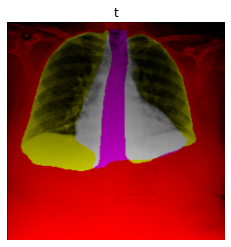

In [155]:
ShowImage(om, 't')

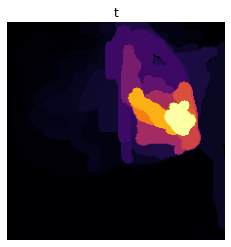

In [156]:
ShowHeatMap(x_out, 't')

In [157]:
mask = x_out >= np.percentile(x_out, 80)
im_mask = np.array(om)
im_mask[~mask] = 1

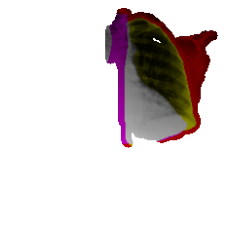

In [158]:
ShowImage(im_mask)

## AUC Plots

In [23]:
def plot_auc(ground, y_hat, title, final_auc, save=False):
    plt.figure(figsize=(8,6), dpi=100)
    fpr, tpr, thresholds = roc_curve(ground, y_hat)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + f', AUC: {final_auc}')
    if save:
        plt.savefig('presentation_figs/final_auc.png')

In [13]:
verc = [[full_ground, hsiao_full, f'UCSD Full, AUROC of {np.round(hsiao_full_auc, 3)}', f'UCSD Full, AUPRC of {np.round(hsiao_full_prc, 3)}'], 
        [full_ground, mim_full, f'MIMIC Full, AUROC of {np.round(mim_full_auc, 3)}', f'MIMIC Full, AUPRC of {np.round(mim_full_prc, 3)}'], 
        [seg_ground, hsiao_seg, f'UCSD Segmented, AUROC of {np.round(hsiao_seg_auc, 3)}', f'UCSD Segmented, AUPRC of {np.round(hsiao_seg_prc, 3)}'], 
        [seg_ground, mim_seg, f'MIMIC Segmented, AUROC of {np.round(mim_seg_auc, 3)}', f'MIMIC Segmented, AUPRC of {np.round(mim_seg_prc, 3)}']]
rocs = []
prcs = []
for ver in verc:
    fpr, tpr, thresholds = roc_curve(ver[0], ver[1])
    precision, recall, thresholds = precision_recall_curve(ver[0], ver[1])
    roc = pd.DataFrame([fpr,tpr]).T
    roc.columns = ['False Positive Rate', 'True Positive Rate']
    roc['Model'] = [ver[2]] * len(roc)
    prc = pd.DataFrame([precision, recall]).T
    prc.columns = ['Precision', 'Recall']
    prc['Model'] = [ver[3]] * len(prc)
    rocs.append(roc)
    prcs.append(prc)
all_rocs = pd.concat(rocs)
all_prcs = pd.concat(prcs)

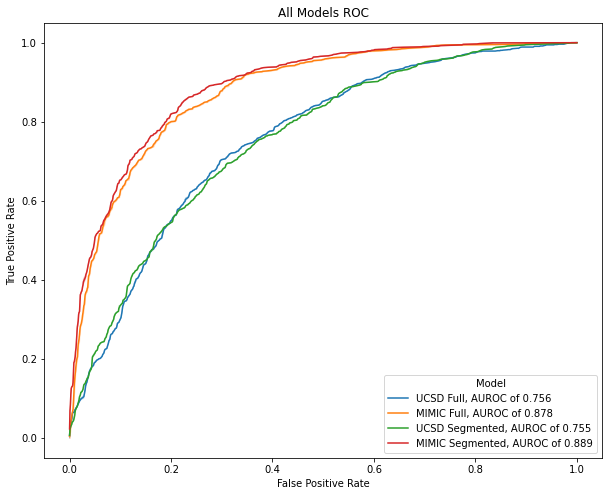

In [22]:
plt.figure(figsize=(10,8))
sns.lineplot(data=all_rocs, x='False Positive Rate', y='True Positive Rate', hue='Model').set(title = 'All Models ROC')
plt.savefig('final_figs/all_roc.png', pad_inches=0.2, bbox_inches='tight')

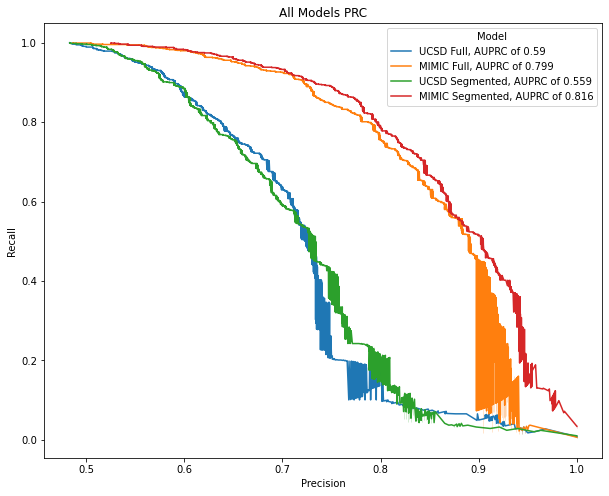

In [23]:
plt.figure(figsize=(10,8))
sns.lineplot(data = all_prcs, x='Precision', y='Recall', hue='Model').set(title='All Models PRC')
plt.savefig('final_figs/all_prc.png', pad_inches=0.2, bbox_inches='tight')

In [38]:
full = '/home/jmryan/teams/dsc-180a---a14-[88137]/mimic_224_pandas/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35_224.pandas'
lung = '/home/jmryan/teams/dsc-180a---a14-[88137]/mimic_seg_lung_224_pandas/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35_224.pandas'
heart = '/home/jmryan/teams/dsc-180a---a14-[88137]/mimic_seg_heart_224_pandas/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35_224.pandas'

/home/jmryan/teams/dsc-180a---a14-[88137]/mimic_224_pandas/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35_224.pandas /home/jmryan/teams/dsc-180a---a14-[88137]/mimic_seg_lung_224_pandas/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35_224.pandas /home/jmryan/teams/dsc-180a---a14-[88137]/mimic_seg_heart_224_pandas/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35/bf2f7b51-95151649-fdf6dcc7-5580045e-234e3a35_224.pandas


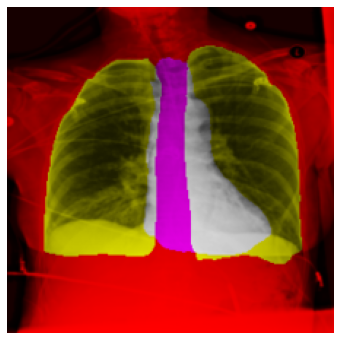

In [53]:
plt.figure(figsize=(6,6))
plt.imshow(torch.moveaxis(mim_seg_test_dataset[0][0], 0, 2))
plt.axis('off')
plt.savefig('final_figs/final_segmentation.png', pad_inches=0, bbox_inches='tight')

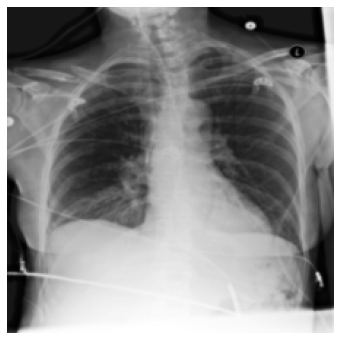

In [52]:
plt.figure(figsize=(6,6))
plt.imshow(torch.load(full), cmap='gray')
plt.axis('off')
plt.savefig('final_figs/full_segmentation.png', pad_inches=0, bbox_inches='tight')